In [12]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import copy
import os

import net.utils as utils
from net.aams import SelfAttention
from net.aams import Encoder, Decoder

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of aams failed: Traceback (most recent call last):
  File "/home/dehezhang2/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/dehezhang2/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/dehezhang2/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/dehezhang2/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/dehezhang2/Desktop/github/style-transfer-with-style-attention/net/aams.py", line 4, in <module>
    import net.utils as utils
ModuleNotFoundError: No module

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
a = torch.arange(120).view(2, 3, 4, 5)
utils.batch_mean_image_subtraction(a)

tensor([[[[ -0.4850,   0.5150,   1.5150,   2.5150,   3.5150],
          [  4.5150,   5.5150,   6.5150,   7.5150,   8.5150],
          [  9.5150,  10.5150,  11.5150,  12.5150,  13.5150],
          [ 14.5150,  15.5150,  16.5150,  17.5150,  18.5150]],

         [[ 19.5420,  20.5420,  21.5420,  22.5420,  23.5420],
          [ 24.5420,  25.5420,  26.5420,  27.5420,  28.5420],
          [ 29.5420,  30.5420,  31.5420,  32.5420,  33.5420],
          [ 34.5420,  35.5420,  36.5420,  37.5420,  38.5420]],

         [[ 39.5924,  40.5924,  41.5924,  42.5924,  43.5924],
          [ 44.5924,  45.5924,  46.5924,  47.5924,  48.5924],
          [ 49.5924,  50.5924,  51.5924,  52.5924,  53.5924],
          [ 54.5924,  55.5924,  56.5924,  57.5924,  58.5924]]],


        [[[ 59.5150,  60.5150,  61.5150,  62.5150,  63.5150],
          [ 64.5150,  65.5150,  66.5150,  67.5150,  68.5150],
          [ 69.5150,  70.5150,  71.5150,  72.5150,  73.5150],
          [ 74.5150,  75.5150,  76.5150,  77.5150,  78.5150]],

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
    ])
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset('../datasets/content_set/val2014', data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=8,
    num_workers=2)
train_iter = iter(train_loader)

torch.Size([3, 256, 256])


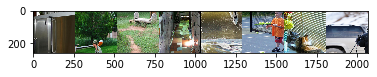

In [8]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [5]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()
encoder= Encoder(vgg19)
print(encoder)
decoder= Decoder().cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
)
Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5):

In [6]:
for input_batch in train_loader:
    input_batch = input_batch.to(device)
    print(input_batch.size())
    out = encoder(input_batch)
    print(out['conv4'].size())
    recon = decoder(out['conv4'], out)
    print(recon.size())
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 512, 32, 32])
torch.Size([8, 3, 256, 256])


In [8]:
arr = [0,1,2,3,4,5]
print(arr)

[0, 1, 2, 3, 4, 5]
